# Visium HD tutorial

We can run Sopa on Visium HD, as the 2 micron bins are subcellular. You can follow the ["normal" API tutorial](../api_usage), or continue below to get exemples more specific to Visium HD data.

For this tutorial, we use the [mouse small intestine public dataset](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine) from 10X Genomics.


In [1]:
import sopa
import spatialdata
import spatialdata_plot

/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Reading the data


In [ ]:
sdata = sopa.io.visium_hd("data/visium_hd/Visium_HD_Mouse_Small_Intestine")
sdata

Then, we save it on-disk:


In [2]:
sdata.write("mouse_small_intestine.zarr")  # save it

sdata = spatialdata.read_zarr("mouse_small_intestine.zarr")  # open-it back

/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'read_only'
  warn('ignoring keyword argument %r' % k)
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'read_only'
  warn('ignoring keyword argument %r' % k)
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'read_only'
  warn('ignoring keyword argument %r' % k)
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'read_only'
  warn('ignoring keyword argument %r' % k)
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'read_only'
  warn('ignoring keyword argument %r' % k)
/Users/quentinblampey/min

## Usual pipeline


Now, we run Sopa as usual. Although, since we don't have transcripts, we can't run Baysor. Therefore, we will run [Stardist](https://github.com/stardist/stardist) on the H&E image.


In [12]:
sopa.segmentation.tissue(sdata, expand_radius_ratio=0.02)

[INFO] (sopa.segmentation._tissue) Using image_key='Visium_HD_Mouse_Small_Intestine_hires_image' and mode='saturation' as default
[WARNING] (sopa.segmentation._tissue) sdata['region_of_interest'] was already existing, but tissue segmentation is run on top


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0995671..1.0].


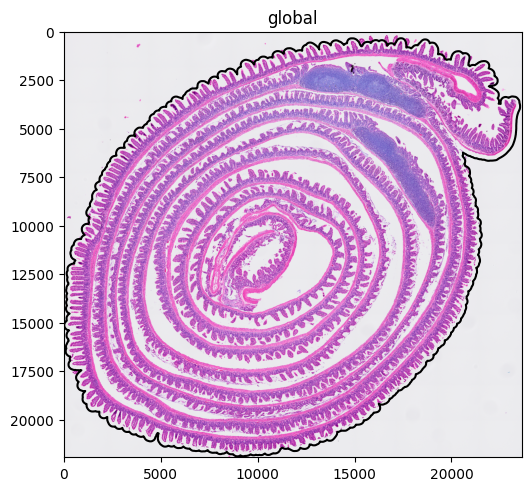

In [13]:
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_hires_image").pl.render_shapes(
    "region_of_interest", outline_alpha=1, fill_alpha=0
).pl.show("global")

First, we create the patches for the cell segmentation.


In [5]:
sopa.make_image_patches(sdata)

[INFO] (sopa.patches._patches) Added 156 patche(s) to sdata['image_patches']


Now we can run stardist on the H&E image. Here, we decrease `prob_thresh` and increase `nms_thresh` to get more cells.


In [ ]:
sopa.segmentation.stardist(sdata, min_area=30)

[WARNING] (sopa._settings) Running without parallelization backend can be slow. Consider using a backend, e.g. via `sopa.settings.parallelization_backend = 'dask'`, or `export SOPA_PARALLELIZATION_BACKEND=dask`.
  3%|▎         | 4/156 [00:34<22:03,  8.71s/it]

  3%|▎         | 5/156 [00:36<16:07,  6.40s/it]

  4%|▍         | 6/156 [00:40<13:52,  5.55s/it]

## Aggregation


Now, we need to run [`sopa.aggregate`](../../api/aggregation/#sopa.aggregate) to aggregate the bins into the cells. For each cell, we expand their radius, and then Sopa will sum the transcript counts of all 2-microns-bins touching or included within the cell.

Here, `expand_radius_ratio = 1`, which means that the cells will be expanded a value of `1 * mean_radius` before aggregating the means. You can choose any positive float value.

> There is an argument `bins_key`, but by default Sopa will understand that it's Visium HD data and that it should use the 2-microns bins. Also, on the example below, we only aggregate the bins, not the H&E channels.


In [9]:
sopa.aggregate(sdata, aggregate_channels=False, expand_radius_ratio=1)

aligned_df.py (68): Transforming to str index.
_elements.py (104): Key `stardist_boundaries` already exists. Overwriting it in-memory.


## Single-cell table


Now, we have an AnnData object with the gene expression **per cell**.


In [10]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 408458 × 19059
    obs: 'region', 'slide', 'cell_id', 'area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial'

For instance, we can now use Scanpy to plot gene expression.


In [11]:
import scanpy as sc

In [12]:
# basic preprocessing
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

We can then use `sc.pl.spatial` to show the gene expression per cells. Note that, here, we show **cells**, not bins.


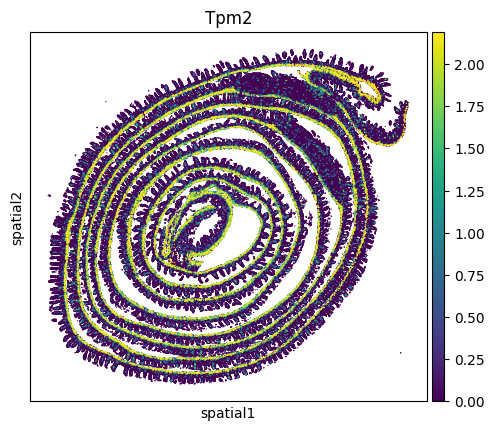

In [13]:
sc.pl.spatial(adata, color="Tpm2", spot_size=80, vmax="p98")

## Bins visualization

The 2-micron bins are arranged in a grid, so they can be visualized as an image of `G` channels, where `G` is the number of genes.

Creating the image would be massive, so we need to create it lazily. This can be done with `spatialdata.rasterize_bins`.


In [ ]:
sdata["square_002um"].X = sdata["square_002um"].X.tocsc()  # optimisation with the csc format

lazy_bins_image = spatialdata.rasterize_bins(
    sdata,
    bins="Visium_HD_Mouse_Small_Intestine_square_002um",  # key of the bins shapes
    table_name="square_002um",  # key of the table with the bins gene expression
    row_key="array_row",
    col_key="array_col",
)

Note that `lazy_bins_image` is an image of size `(19059, 690, 690)`, that is `G=19059` genes, and `690x690` bins. This would correspond to a 33.80GB image in memory, if it wasn't lazy.


In [ ]:
lazy_bins_image

We can save this image in the `sdata` object.


In [13]:
sdata["gene_expression_2_um"] = lazy_bins_image

Then, we can visualize this image with Napari. When showing a gene, it will compute the corresponding layer of the lazy image, and it will be displayed in milliseconds, i.e. looking instantaneous.


In [ ]:
from napari_spatialdata import Interactive

Interactive(sdata)

You'll be able to display cells and the bins expression. It should look like that:

<p align="center">
  <img src="../../assets/napari_visium_hd.png" alt="napari_visium_hd" width="600px"/>
</p>


## Xenium Explorer

Although the Xenium Explorer can be used (as below), it will not display the bins. If you want to see the bins, use `Napari` as detailed above.


In [15]:
sopa.io.explorer.write("mouse_small_intestine.explorer", sdata)

[INFO] (sopa.io.explorer.table) Writing table with 18166 columns
[INFO] (sopa.io.explorer.table) Writing 2 cell categories: region, slide
[INFO] (sopa.io.explorer.shapes) Writing 332556 cell polygons
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (3, 21943, 23618)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 21943, 23618)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 10971, 11809)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 5485, 5904)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 2742, 2952)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 1371, 1476)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 685, 738)
[INFO] (sopa.io.explorer.converter) Saved files in the following directory: mouse_small_intestine.explorer
[INFO] (sopa.io.explorer.converter) You can open the experiment with 'open